# LOFAR single station imaging

Based on version 1.4 of V.A. Moss's tutorial, tutorial from M.A. Brentjens 8/8/2017.

In [1]:
import os
import sys
import time
import datetime
import glob
import numpy as np

from scipy import ndimage

from lofarantpos.db import LofarAntennaDatabase

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

In [3]:
# We need lofarantpos >= 0.4.0 to get the station rotations

from packaging import version
import lofarantpos
assert(version.parse(lofarantpos.__version__) >= version.parse("0.4.0"))

In [4]:
from lofarimaging import find_caltable, sb_from_freq, freq_from_sb, read_caltable, read_acm_cube

In [5]:
start1 = time.time()

In [6]:
# We need python 3.6 for f-string formatting

assert(sys.version_info.major + 0.1*sys.version_info.minor >= 3.6)

In [7]:
# Read all available .dat files
data_dir = "./"
print(f"Searching for available files in {data_dir}")
files = glob.glob(data_dir + "/*.dat")
for file_index, filename in enumerate(files):
    print(f"{file_index}: {filename}")

Searching for available files in ./
0: ./20170720_095816_mode_3_xst_sb297.dat


In [8]:
# Select a file
cubefile = files[0]

print("File selected:", cubefile)

File selected: ./20170720_095816_mode_3_xst_sb297.dat


In [216]:
# Initialisation parameters
# Modified to match output from M. Mancini script
cubename = os.path.basename(cubefile)
station = 'DE603LBA'
stype = 'intl'

# Make directory for results
# Note... this won't work for windows...
try:
    os.mkdir('results')
except FileExistsError:
    print("results directory already exists...\n")

# Distill metadata from filename
obsdatestr, obstime, _, stationtype, _, subbandname = cubename.rstrip(".dat").split("_")
subband = int(subbandname[2:])
    
# Needed for NL stations: inner (mode 3/4), outer (mode 1/2), (sparse tbd)
# Should be set to 'inner' if station type = 'intl'
if stationtype in ('1', '2'):
    atype == 'outer'
elif stationtype in ('3', '4'):
    atype = 'inner'
else:
    raise Exception("Unexpected mode: ", stationtype)

# Get the data
fname = f"{obsdatestr}_{obstime}_{station}_SB{subband}"

im_x, im_y = 101, 101
freq = freq_from_sb(subband)

# Which slice in time to visualise
timestep = 0

# Calculate start time
starttime = datetime.datetime.strptime(obstime, '%H%M%S')

# For ground imaging
dims = np.array([-150, 150, -150, 150]) # metres in the localnorth frame (relative to station phase center)
height = 1.5 # metres

# Confirm the data has been read correctly
print(f"""Filename: {cubename}
Station: {station}
Station type: {stype}
Array type: {atype}
Subband: {subband}
Timestep: {timestep}
Save title: {fname}
Sky image size: {im_x:d} x {im_y:d}
Ground image size: {dims[1]-dims[0]:d} x {dims[3]-dims[2]:d} m 
Ground height: {height} m
""")

results directory already exists...

Filename: 20170720_095816_mode_3_xst_sb297.dat
Station: DE603LBA
Station type: intl
Array type: inner
Subband: 297
Timestep: 0
Save title: 20170720_095816_DE603LBA_SB297
Sky image size: 101 x 101
Ground image size: 300 x 300 m 
Ground height: 1.5 m



In [217]:
SPEED_OF_LIGHT = 299792458.0

def sky_imager(visibilities, baselines, freq, im_x, im_y):
    """Do a Fourier transform for sky imaging"""
    img = np.zeros([im_y, im_x], dtype=np.float32)
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="invalid value encountered in sqrt")
        warnings.filterwarnings("ignore", message="Casting complex values to real discards the imaginary part")
        for m_ix, m in enumerate(np.linspace(-1, 1, im_x)):
            for l_ix, l in enumerate(np.linspace(1, -1, im_y)):
                n = np.sqrt(1 - l**2 - m**2)
                img[m_ix,l_ix] = np.mean(visibilities *
                                         np.exp(-2j * np.pi * freq *
                                                (baselines[:,:,0] * l + baselines[:,:,1] * m)/SPEED_OF_LIGHT))
    return img

def ground_imager(visibilities, baselines, freq, im_x, im_y, dims, station_pqr, height=1.5):
    """Do a Fourier transform for ground imaging"""
    img = np.zeros([im_y, im_x], dtype=np.float32)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Casting complex values to real discards the imaginary part")
        for q_ix, q in enumerate(np.linspace(dims[2], dims[3], im_y)):
            for p_ix, p in enumerate(np.linspace(dims[0], dims[1], im_x)):
                r = height
                pqr = np.array([p, q, r], dtype=np.float32)
                antdist = np.linalg.norm(station_pqr - pqr[np.newaxis, :], axis=1)    
                groundbase = np.zeros([len(station_pqr),len(station_pqr)], dtype='float32')
                for i in range(0,len(station_pqr)):
                    groundbase[i] = antdist[i] - antdist[:]
                # Note: this is RFI integration second - normal second, to take out interference
                img[q_ix,p_ix] = np.mean(visibilities*np.exp(-2j*np.pi*freq*(-groundbase)/SPEED_OF_LIGHT))
    return img

In [218]:
# Read cube
cube = read_acm_cube(cubefile, stype)

In [219]:
# Print shape of cube
cube.shape, cube.dtype

((29, 192, 192), dtype('complex128'))

In [220]:
find_caltable(station, rcu_mode = atype)

'caltables/CalTable-603-LBA_INNER-10_90.dat'

In [221]:
# Apply calibration 

caltable_filename = find_caltable(station, rcu_mode=atype, config_dir="caltables")

if caltable_filename is None:
    print('No calibration table found... cube remains uncalibrated!')
else:
    cal_header, cal_data = read_caltable(caltable_filename)
    print(''.join(cal_header))
    rcu_gains = cal_data[subband, :]
    rcu_gains = np.array(rcu_gains, dtype=np.complex64)
    gain_matrix = rcu_gains[np.newaxis, :] * np.conj(rcu_gains[:, np.newaxis])
    cube = cube / gain_matrix

HeaderStart
CalTableHeader.Observation.Station = DE603
CalTableHeader.Observation.Mode = 3
CalTableHeader.Observation.AntennaSet = LBA_INNER
CalTableHeader.Observation.Band = 10_90
CalTableHeader.Observation.Source = CasA, CygA, VirA, TauA, Sun
CalTableHeader.Observation.Date = 201612271045
CalTableHeader.Calibration.Version = 0
CalTableHeader.Calibration.Name = L.Cerrigone
CalTableHeader.Calibration.Date = 20170403
CalTableHeader.Calibration.PPSDelay = [12 15 23 30 14 19 24 33 14 16 25 30 11 16 22 29 10 11 20 24 11 17 21 28 10 15 20 29 9 14 20 29 11 16 24 30 13 17 22 33 13 19 24 33 12 15 22 30 9 14 21 24 9 14 20 26 10 15 21 25 14 16 23 30 14 19 24 29 13 18 24 28 11 14 20 24 13 16 24 29 12 16 23 29 12 17 24 30 9 13 20 23 10 15 22 28 ]
CalTableHeader.Comment = Manually flagged: several
HeaderStop



In [222]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse 
cube_xx = cube[:, 0::2, 0::2]
cube_yy = cube[:, 1::2, 1::2]
visibilities_all = cube_xx + cube_yy

# Stokes I for specified timestep
visibilities = visibilities_all[timestep]

In [223]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape, visibilities.shape, visibilities.dtype

((29, 96, 96), (29, 96, 96), (96, 96), dtype('complex128'))

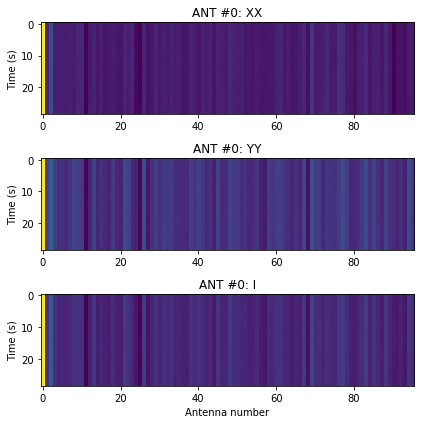

In [224]:
# Check how the various antennas/polarisation look with time
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax0.imshow(cube_xx[:, 0, :].real, aspect='auto')
ax0.set_ylabel('Time (s)')
ax0.set_title('ANT #0: XX')
ax1.imshow(cube_yy[:,0,:].real,aspect='auto')
ax1.set_title('ANT #0: YY')
ax1.set_ylabel('Time (s)')
ax2.imshow(visibilities_all[:,0,:].real,aspect='auto')
ax2.set_title('ANT #0: I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Time (s)')
plt.tight_layout()

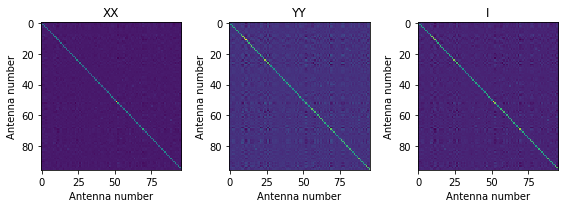

In [225]:
# Check how the correlations look
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax0.imshow(cube_xx[0,:,:].real, aspect='auto')
ax0.set_xlabel('Antenna number')
ax0.set_ylabel('Antenna number')
ax0.set_title('XX')
ax1.imshow(cube_yy[0,:,:].real, aspect='auto')
ax1.set_title('YY')
ax1.set_xlabel('Antenna number')
ax1.set_ylabel('Antenna number')
ax2.imshow(visibilities.real, aspect='auto')
ax2.set_title('I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Antenna number')
plt.tight_layout()

In [226]:
# Setup the database
db = LofarAntennaDatabase()

In [227]:
# Get the PQR positions for an individual station
station_pqr = db.antenna_pqr(station)

# Exception: for Dutch stations (sparse not yet accommodated)
if (stype == 'core' or stype == 'remote') and atype == 'inner':
    station_pqr = station_pqr[0:48,:]
elif (stype == 'core' or stype == 'remote') and atype == 'outer':
    station_pqr = station_pqr[48:,:]

station_pqr = station_pqr.astype('float32')

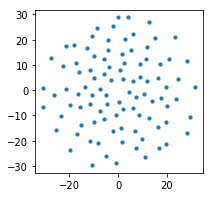

In [228]:
# Plot these positions (see layout of LBA)
plt.figure(figsize=(3,3))
plt.scatter(station_pqr[:,0],station_pqr[:,1],s=10);

In [229]:
# Check the shape of the PQR cube
station_pqr.shape

(96, 3)

In [230]:
# For every antenna, calculate the "distance" between it and every other antenna
baselines = station_pqr[:, np.newaxis, :] - station_pqr[np.newaxis, :, :]

In [231]:
# Check the shape of the baselines array
baselines.shape

(96, 96, 3)

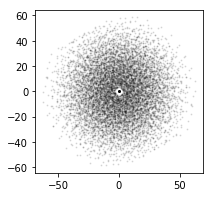

In [232]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
plt.figure(figsize=(3,3))
plt.scatter(baselines[:,:,0], baselines[:,:,1], facecolor='k', edgecolor='k', s=1, alpha=0.1);

In [233]:
# Account for the rotation
rotation = np.rad2deg(db.rotation_from_north(station))
print ('Rotation for %s: %.2f deg' % (station,rotation))

Rotation for DE603LBA: 3.84 deg


In [234]:
# Make a sky image, by numerically Fourier-transforming from visibilities to image plane
from matplotlib.patches import Circle

# Fourier transform, and account for the rotation (rotation is positive in this space)
# visibilities = cube_xx[2,:,:]
img = sky_imager(visibilities, baselines, freq, im_x, im_y)
img = ndimage.interpolation.rotate(img, -rotation, reshape=False, mode='constant', cval=np.nan)

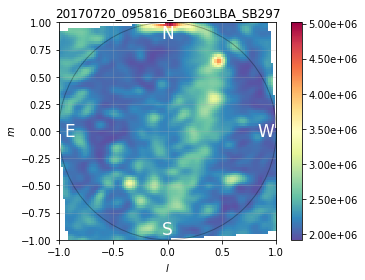

In [235]:
# Plot the resulting sky image
fig, ax = plt.subplots(1)
cimg = ax.imshow(img, origin='lower', cmap=cm.Spectral_r, extent=(-1,1,-1,1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.2e")

circle1 = Circle((0,0), 1.0, edgecolor='k', fill=False, alpha=0.3)
ax.add_artist(circle1)

# Labels
ax.set_xlabel('$l$')
ax.set_ylabel('$m$')
#ax.set_title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Plot the compass directions
ax.text(0.9, 0, 'W', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(-0.9, 0, 'E', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, 0.9, 'N', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, -0.9, 'S', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)

ax.grid(True, alpha=0.3)

plt.savefig(f'results/{fname}_sky_calibrated.png', bbox_inches='tight', dpi=200)

In [236]:
def get_extents_pqr(db, station, extents_localnorth, margin=5):
    """
    Get the extents of a rectangular grid in the PQR frame which contains the
    entire extents in the localnorth frame.
    A bit of margin is taken to accomodate for interpolation after rotation.
    
    Args:
        extents_localnorth: extents in the form [xmin, xmax, ymin, ymax]
    
    Returns:
        extents in the PQR frame, in the form [pmin, pmax, qmin, qmax]
    """
    rot_matrix = db.pqr_to_localnorth(station)[:2, :2]
    [xmin, xmax, ymin, ymax] = extents_localnorth
    pmin2, _ = rot_matrix @ [xmin, ymin]
    _, qmin2 = rot_matrix @ [xmax, ymin]
    pmax2, _ = rot_matrix @ [xmax, ymax]
    _, qmax2 = rot_matrix @ [xmin, ymax]
    return [pmin2-margin, pmax2+margin, qmin2-margin, qmax2+margin]

In [237]:
# Make a ground image, by numerically Fourier-transforming from visibilities to ground plane

# NOTE: dims currently must be centered on (0,0) for the rotation to work!
assert(np.mean([dims[0], dims[1]]) == 0)
assert(np.mean([dims[2], dims[3]]) == 0)
ratio = 0.5 # how many pixels per metre, default is 0.5 pixel/metre
im_x, im_y = int(ratio*(abs(dims[1]-dims[0]))),int(ratio*(abs(dims[3]-dims[2])))
dims2 = get_extents_pqr(db, station, dims) # image further to account for rotation post-transform

# Fourier transform (rotation is negative in this space)
img = ground_imager(visibilities, baselines, freq, im_x, im_y, dims2, station_pqr, height=1.5)
img_rotated = ndimage.interpolation.rotate(img, rotation, reshape=False, mode='constant', cval=np.nan)

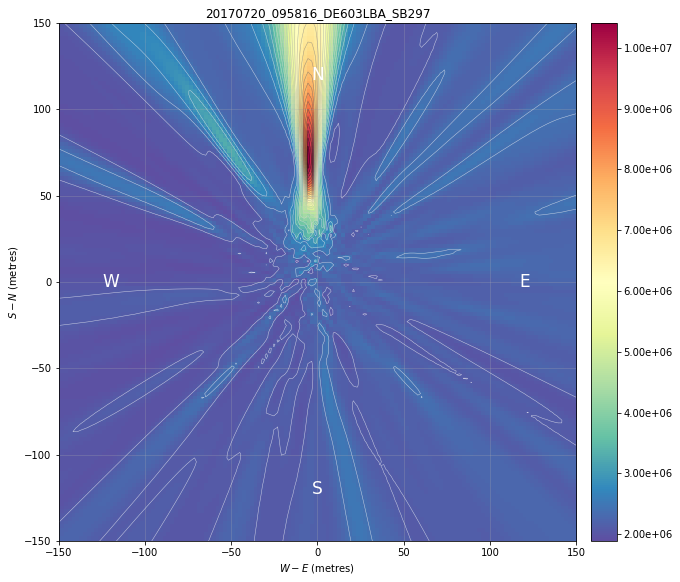

In [238]:
# Plot the resulting image
fig, ax = plt.subplots(figsize=(10,10))
cimg = ax.imshow(img_rotated, origin='lower', cmap=cm.Spectral_r, extent=dims2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.2e")

ax.set_xlabel('$W-E$ (metres)')
ax.set_ylabel('$S-N$ (metres)')
#title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Custom range for dims (set to whatever is needed to zoom)
#dims = np.array([-150,0,-100,50]) # metres

# Change limits to match the original specified extent in the localnorth frame
ax.set_xlim(dims[0],dims[1])
ax.set_ylim(dims[2],dims[3])

# Place the NSEW coordinate directions
ax.text(0.9, 0.5, 'E', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.1, 0.5, 'W', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.9, 'N', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.1, 'S', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

ax.contour(img_rotated, 30, origin='lower', cmap=cm.Greys, extent=dims2, linewidths=0.5, alpha=0.7)
ax.grid(True, alpha=0.3)
plt.savefig(f"results/{fname}_nearfield_calibrated.png", bbox_inches='tight', dpi=200)

In [239]:
# Make colors semi-transparent in the lower quarter of the scale
cmap = cm.Spectral_r
cmap_with_alpha = cmap(np.arange(cmap.N))
cmap_with_alpha[:,-1] = np.clip(np.linspace(0, 4, cmap.N), 0., 1.)
cmap_with_alpha = ListedColormap(cmap_with_alpha)

In [240]:
plt.imsave(f"results/{fname}_nearfield_calibrated_noaxes.png", img_rotated,
           cmap=cmap_with_alpha, origin='lower')

In [241]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Time elapsed: 2129.17 s


Export the near field image to GeoTIFF for archiving and viewing in other tools (QGIS).

In [242]:
import lofargeotiff

In [243]:
obsdate = datetime.datetime.strptime(obsdatestr + ":" + obstime, '%Y%m%d:%H%M%S')

Get actual extents in the produced plot.

In [244]:
pmin, qmin, _ = db.pqr_to_localnorth(station).T @ [dims[0], dims[2], 0]
pmax, qmax, _ = db.pqr_to_localnorth(station).T @ [dims[1], dims[3], 0]

In [245]:
tags = {"datafile": cubefile,
        "generated_with": "LOFAR LBA imaging tutorial v1.4",
        "caltable": caltable_filename}
lofargeotiff.write_geotiff(img, f"results/{fname}_nearfield_calibrated.tiff",
                           (pmin, qmin), (pmax, qmax), stationname=station,
                           obsdate=obsdate)

Overlay the near field image on a map.

In [246]:
import folium

In [247]:
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0, 0, 0], station)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station)

In [248]:
m = folium.Map(location=[lat_center, lon_center], zoom_start=18,
               tiles='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}',
               attr='ESRI')
folium.TileLayer(tiles="OpenStreetMap").add_to(m)

folium.raster_layers.ImageOverlay(
   name='Near field image',
   image=f"results/{fname}_nearfield_calibrated_noaxes.png",
   bounds=[[lat_min, lon_min], [lat_max, lon_max]],
   opacity=0.6,
   interactive=True,
   cross_origin=False,
   zindex=1
).add_to(m)

folium.LayerControl().add_to(m)
m

In [249]:
from owslib.wmts import WebMapTileService

In [250]:
wmts = WebMapTileService("http://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/WMTS/1.0.0/WMTSCapabilities.xml")

In [251]:
import mercantile

In [252]:
zoom = 19

In [253]:
def get_tile_nrs(lon_min, lon_max, lat_min, lat_max, zoom):
    tile_min = mercantile.tile(lon_min, lat_min, zoom)
    tile_max = mercantile.tile(lon_max, lat_max, zoom)
    for x in range(tile_min.x, tile_max.x + 1):
        for y in range(tile_max.y, tile_min.y + 1):
            yield x, y

In [254]:
upperleft_tile = mercantile.tile(lon_min, lat_max, zoom)
xmin, ymin = upperleft_tile.x, upperleft_tile.y
lowerright_tile = mercantile.tile(lon_max, lat_min, zoom)
xmax, ymax = lowerright_tile.x, lowerright_tile.y

total_image = np.zeros([256*(ymax-ymin+1), 256*(xmax-xmin+1), 3], dtype='uint8')

for x, y in get_tile_nrs(lon_min, lon_max, lat_min, lat_max, zoom):
    tile = wmts.gettile(layer="World_Imagery", tilematrix=zoom, row=y, column=x)
    out = open("tmp.jpg", "wb")
    out.write(tile.read())
    out.close()
    tile_image = plt.imread("tmp.jpg")
    total_image[(y - ymin) * 256 : (y - ymin +1) * 256,
                (x - xmin) * 256 : (x - xmin +1) * 256] = tile_image

In [255]:
total_lonlatmin = {'lon': mercantile.bounds(xmin, ymax, zoom).west, 'lat': mercantile.bounds(xmin, ymax, zoom).south}
total_lonlatmax = {'lon': mercantile.bounds(xmax, ymin, zoom).east, 'lat': mercantile.bounds(xmax, ymin, zoom).north}

In [256]:
pix_xmin = int(round(np.interp(lon_min, [total_lonlatmin['lon'], total_lonlatmax['lon']], [0, total_image.shape[1]])))
pix_ymin = int(round(np.interp(lat_min, [total_lonlatmin['lat'], total_lonlatmax['lat']], [0, total_image.shape[0]])))
pix_xmax = int(round(np.interp(lon_max, [total_lonlatmin['lon'], total_lonlatmax['lon']], [0, total_image.shape[1]])))
pix_ymax = int(round(np.interp(lat_max, [total_lonlatmin['lon'], total_lonlatmax['lon']], [0, total_image.shape[0]])))

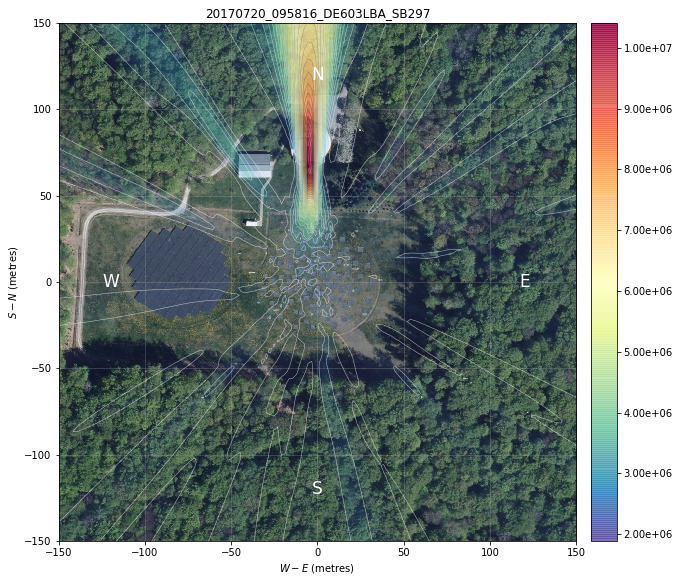

In [257]:
# Plot the resulting image
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(total_image[pix_ymin: pix_ymax, pix_xmin: pix_xmax], extent=dims)
cimg = ax.imshow(img_rotated, origin='lower', cmap=cmap_with_alpha, extent=dims2, alpha=0.8)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2, axes_class=maxes.Axes)
fig.colorbar(cimg, cax=cax, orientation="vertical", format="%.2e")

ax.set_xlabel('$W-E$ (metres)')
ax.set_ylabel('$S-N$ (metres)')
#title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Custom range for dims (set to whatever is needed to zoom)
#dims = np.array([-150,0,-100,50]) # metres

# Change limits to match the original specified extent in the localnorth frame
ax.set_xlim(dims[0],dims[1])
ax.set_ylim(dims[2],dims[3])

# Place the NSEW coordinate directions
ax.text(0.9, 0.5, 'E', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.1, 0.5, 'W', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.9, 'N', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.1, 'S', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

ax.contour(img_rotated, 30, origin='lower', cmap=cm.Greys, extent=dims2, linewidths=0.5, alpha=0.7)
ax.grid(True, alpha=0.3)
ax.set_aspect(1)
plt.savefig(f"results/{fname}_nearfield_calibrated.png", bbox_inches='tight', dpi=200)